# Lab 3: 机器学习进阶技巧：特征工程和集成(Ensemble)模型

# Review

- Q1: 上节课机器学习的三个关键步骤是什么？
- Q2: 怎么理解AUC？
- Q3: 怎么知道你是否过拟合了？
- Q4: 怎么进行parameter grid的选择？

## 2.1 Context 

### 2.1.1 元数据(Metadata)
| Column | Description | Type |
|--------|-------------|------|
| person_age | Age of the person | Float |
| person_gender | Gender of the person | Categorical |
| person_education | Highest education level | Categorical |
| person_income | Annual income | Float |
| person_emp_exp | Years of employment experience | Integer |
| person_home_ownership | Home ownership status (e.g., rent, own, mortgage) | Categorical |
| loan_amnt | Loan amount requested | Float |
| loan_intent | Purpose of the loan | Categorical |
| loan_int_rate | Loan interest rate | Float |
| cb_person_cred_hist_length | Length of credit history in years | Float |
| credit_score | Credit score of the person | Integer |
| loan_status (target variable) | Loan approval status: 1 = approved; 0 = rejected | Integer |

### 2.1.2 提供技术环境信息

- 请使用pandas， matplotlib， sklearn这三个python package（也可以在mdc文件中设置）

- 项目目录结构
```
|
|- data // 数据目录
|   |-- loan_data.csv
|- lab.ipynb
```

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
# 设置中文字体
try:
    plt.rcParams['font.sans-serif'] = ['Heiti TC'] # 或者 'Arial Unicode MS', 'PingFang SC' 等
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"设置中文字体失败: {e}。标签可能显示不正确。")

In [14]:
data = pd.read_csv('data/loan_data.csv').query('previous_loan_defaults_on_file=="No"')
X = data.drop('loan_status', axis=1)
y = data['loan_status']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. 特征工程

## 1.1 基础特征工程

特征工程一般有以下几种操作

- 异常值处理：（审慎）删除，以某个极值替代（例如年龄cap在100岁）

- 缺失值处理：删除【不推荐】，以均值或者众数填写

- One-hot Encoding：某些数据集会用数字来存储离散变量，再给一个code book（特别是社会科学的数据集，为了适配SPSS和Stata）。如果不做One-hot encoding会被当作数值变量处理

- 特征缩放：这避免某些特征的尺度对于其他特征的影响。比如把某个省的GDP和它的上年增长率放在一起，GDP的尺度会对于模型产生显著影响。特征缩放有两种常见方法，正态化或者range归一

- 高阶项（和交叉项）：虽然高阶项对于不同模型的好处并不完全相同，但是一般使用高阶项实际上是在做一个泰勒展开，去近似更复杂的function form（特别是对于SVM/Logit这样的线性模型）

这一节我们主要展示特征缩放和高阶项。

```
请构建一个pipeline，包含
1. 对于person_income,loan_amnt,credit_score的正态化scaling和对于person_age的range归一
2. 将上面两种变化后的变量 构建2阶polynomial
2. 对所有的categorical 做one-hot encoding，并构建2阶interaction only的polynomial
3. 使用decision tree classifer，基于auc_roc的5 fold crossvalidation 对criterion，max_depth，min_samples_split和min_samples_leaf四个参数进行grid search

汇报在train和test数据上的AUC，并将两个数据集的ROC画到一张图上
```

### 讨论
1. pipeline在其中起了什么作用？
2. 增加了特征后，模型表现变好了还是变差了？为什么？

## 1.2 创建业务特征

上一节课的结尾，我说这节课我们会开始code insight。 其中一个重要的做法就是做特征。比如，在贷款业务中，income/loan ratio 是一个非常重要的业务指标，而在我们之前的特征工程中，很难去准确复现这个特征

```
请写一个简单的脚本，在原始data里创建一个新变量，loan_percent_income =  loan_amnt/person_income。使用相同的random state做7:3的train test split，不做pipeline特征工程，仅使用loan_percent_income两个变量做预测，汇报相同的的指标
```

# 2. Ensemble 模型

code insight的另一个重要方法是选择模型。在传统的统计学中（特别是在计量经济学中），选择用什么样的模型来描述数据生成过程是一个大学问。例如在经典的排队问题中，使用泊松模型还是负二次项模型大有讲究。如果未来你在硕士阶段选择了机器学习或者统计学，你会有大量时间花在研究似然函数（Likelihood function）上。

但是在Ensemble模型出现后，这个工作对于大部分场景而言已经不那么重要了。依靠算力大力飞砖被证明是性价比更高的选择。

## 2.1 Random Forest

将pipeline中的decision tree变成random forest，重新估计pipeline，并比较新的结果

让我们看一棵树 【JC DEMO Only】

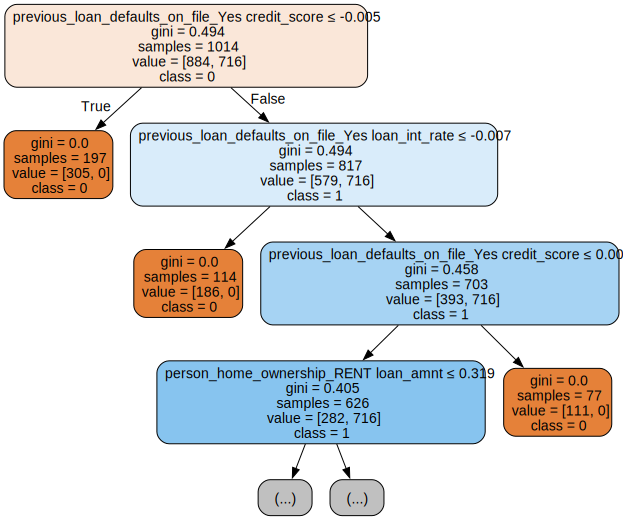

In [5]:
from sklearn.tree import export_graphviz
import graphviz

# 从pipeline中提取随机森林分类器
rf_classifier = pipeline.named_steps['classifier']

# 提取第一棵树
estimator = rf_classifier.estimators_[0]

# 获取特征名称
feature_names = (
    # 获取分类特征的名称
    pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out([
        'person_gender', 'person_education', 'person_home_ownership',
        'loan_intent'
    ]).tolist() +
    # 获取数值特征的名称
    [
        'person_age', 'person_income', 'person_emp_exp',
        'loan_amnt', 'loan_int_rate', 'loan_percent_income',
        'cb_person_cred_hist_length', 'credit_score'
    ]
)

# 获取多项式特征的名称
poly_feature_names = pipeline.named_steps['poly_features'].get_feature_names_out(feature_names)

# 导出树的结构为DOT格式
dot_data = export_graphviz(estimator,
                           out_file=None,
                           feature_names=poly_feature_names,
                           class_names=rf_classifier.classes_.astype(str),
                           filled=True,
                           rounded=True,
                           special_characters=True,
                           max_depth=3)  # 为了简化，可限制深度

# 使用graphviz渲染
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

# 显示图像（在Jupyter Notebook中）
graph


## 2.2 特征重要性
使用Ensemble Model一个重要的好处是可以得到特征重要性。这使得特征工程可以更有针对性

**NOTE** 特征重要性和特征可解释性不一样。ensemble模型告诉你特征很重要，但是并不告诉你这是个正向因素还是个负向因素

## 2.3 Xgboost： Go-To Model Choice

# 总结

这节课我们学习了：
- 如何使用pipeline来串联整个模型训练的routine
- 什么是ensemble模型以及如何对ensemble模型进行调优

**回家作业**： 利用xgboost完成rainfall的完整pipeline，并提交一次Kaggle
